In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
from skimage.data import lfw_subset
import matplotlib.patches as patches

# Excercise 1. AdaBoost
Implement AdaBoost using Python (incl. Numpy etc.) and use it on the SPAM-Dataset
.
The weak classifiers should be decision stumps (i.e. decision trees with one node).


### Import the spambase dataset

In [2]:
data = np.array(pd.read_csv('spambase.data', header=None))

X = data[:,:-1] # features
y = data[:,-1] # Last column is label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, stratify=y)

df_names = pd.read_csv('spambase.names', header=None, names=["feature_names"], skiprows=32)
df_names["feature_names"] = df_names["feature_names"].str.replace(":  *continuous.", "", regex=True)

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3450, 57), (1151, 57), (3450,), (1151,))

### Use the Decision Tree Implementation from Week 6

In [4]:
class ClassificationTree():


    def __init__(self, node_min_size=2, tree_max_depth=None, post_pruning=True):
        """
        If no maximum depth is defined, the nodes are split while they contain at least node_min_size many points.
        If maximum depth is defined, nodes are split further until they contain less than node_min_size many points or
        have reached the maximum number of allowed split levels.
        """
        self.depth = 1
        self.node_min_size = node_min_size
        self.tree_max_depth = tree_max_depth
        self.prune = 0
        self.post_pruning = post_pruning
        self.feature_importances = defaultdict(int)
        
    ################ Tree building ################
    
    def split_data(self, X, j, v):
        """
        Split data X at variable with index j and splitting point v.
        """
        split_left = X[np.where(X[:,j]<=v)]
        split_right = X[np.where(X[:,j]>v)]
        return split_left, split_right

    
    def gini_index(self, groups):
        """
        Calculate gini index for a data set splitted on a certain variable and splitting point.
        groups: two subsets that result from splitting a data set
        y: associated class labels
        """
        gini = 0
        if type(groups[0]) == np.ndarray:
            n = sum(map(len,groups))
            # get class proportions for each split group
            for group in groups:
                size = float(len(group))
                y = group[:,-1]
                if size == 0:
                    continue    
                score = 0
                # sum class proportions within one split groups as sum(p_mk*(1-p_mk))
                for c in set(y):
                    proportions = np.count_nonzero(y==c)/size
                    score += proportions*(1-proportions)
                # sum "inversely squared" class proportions per split group in weighted sum (weighted by proportion of group size)
                gini += score * size/n
        else:
            size = len(groups)
            for c in set(groups):
                proportions = groups.count(c)/size
                gini += proportions*(1-proportions)
        return gini


    def split_node(self, data):
        """
        Find optimal split for a given node "node" and class labels "y" that minimizes the loss function (gini index).
        """
        split_var, split_point, split_gini, groups = 9999, 9999, 9999, None
        # for every candidate split X*p* calculate gini index and select split which minimizes the score
        for j in range(data.shape[1]-1):
            candidate_p = np.unique(X[:,j])
            for v in candidate_p:
                split_groups = self.split_data(data, j, v)
                s = self.gini_index(split_groups) 
                if s < split_gini: 
                    split_var, split_point, split_gini, groups = j, v, s, split_groups
        return {'split_var': split_var, 'split_point': split_point, 'split_gini': split_gini, 'groups': groups}


    def make_leaf(self, node_labels):
        """
        Convert node "node" to leaf by assigning it the majority vote of labels "y".
        """
        leaf_labels = list(node_labels)
        return {'label': max(set(leaf_labels), key=leaf_labels.count), 'class_sizes': [leaf_labels.count(c) for c in set(leaf_labels)]} 

    
    def grow(self, node):
        """
        Recusively split nodes until stopping criteria are fulfilled,
        i.e. a node has too little data points in its region to be splitted further or the the has
        reached its maximum allowd depth.
        """
        left, right = node['groups']
        del(node['groups'])
        # Check for empty nodes (pruned in post-processing)
        if not left.any() or not right.any():
            node['left'] = node['right'] = self.make_leaf(np.r_[left[:,-1], right[:,-1]])
            return None
        # Check for max depth
        if self.tree_max_depth:
            if self.depth >= self.tree_max_depth:
                node['left'] = self.make_leaf(left[:,-1])
                node['right'] = self.make_leaf(right[:,-1])
                return None
        # Check left node size
        if len(left) <= self.node_min_size-1:
            node['left'] = self.make_leaf(left[:,-1])
        else:
            node['left'] = self.split_node(left)
            self.depth += 1
            self.grow(node['left'])
        # Check right node size
        if len(right) <= self.node_min_size:
            node['right'] = self.make_leaf(right[:,-1])
        else:
            node['right'] = self.split_node(right)
            self.depth += 1
            self.grow(node['right'])
        return None
    
    ################ Post-Pruning ################
    
    def check_twin_leaves(self, subtree):
        """
        Prune tree while there still are twin leaves
        """
        if not 'label' in subtree.keys():  
            if 'label' in subtree['left'].keys() and 'label' in subtree['right'].keys():
                if subtree['left']['label'] == subtree['right']['label']:
                    self.prune += 1
            else:
                self.check_twin_leaves(subtree['left'])
                self.check_twin_leaves(subtree['right'])

    def prune_tree(self, subtree):
        """
        If a node results in leaves of the same label, remove leaves and make node to leaf
        """
        # check if A is node or leaf
        if not 'label' in subtree.keys():  
            # at least one subtree B1, B2 has to be a node
            if not 'label' in subtree['left'].keys() or not 'label' in subtree['right'].keys():
                # prune left subtree B1?
                if not 'label' in subtree['left'].keys():
                    tmp = subtree['left']
                    # check if node has two leaves
                    if 'label' in tmp['left'] and 'label' in tmp['right']:
                        if tmp['left']['label'] == tmp['right']['label'] :
                            subtree['left'] = {'label': tmp['left']['label'], 'class_sizes':list(map(sum,list(zip(tmp['left']['class_sizes'],tmp['right']['class_sizes']))))}
                            self.prune -= 1
                            # if B2 is a leaf, decrement depth
                            if 'label' in subtree['right'].keys():
                                self.depth -= 1
                    else:
                        self.prune_tree(tmp)
                # prune right subtree B2?           
                if not 'label' in subtree['right'].keys():
                    tmp = subtree['right']
                    # check if node has two leaves
                    if 'label' in tmp['left'] and 'label' in tmp['right']:
                        if tmp['left']['label'] == tmp['right']['label'] :
                            subtree['right'] = {'label': tmp['left']['label'], 'class_sizes':list(map(sum,list(zip(tmp['left']['class_sizes'],tmp['right']['class_sizes']))))}
                            self.prune -= 1
                            # if B2 is a leaf, decrement depth
                            if 'label' in subtree['left'].keys():
                                self.depth -= 1
                    else:
                        self.prune_tree(tmp)

    ################ Build tree from data  ################
    
    def grow_tree(self, X, y):
        """
        Grow a decision tree for feature data X with class labels y that has at most tree_max_depth many levels
        and at least node_mins_size many data points that support each leaf prediction.
        """
        print('Build tree from data')
        if X.shape[0] <= self.node_min_size:
            raise Exception("Data set is too small to build a tree!")
        root = self.split_node(np.c_[X,y])
        self.grow(root)
        if self.post_pruning:
            print('Post-pruning')
            self.check_twin_leaves(root)
            while self.prune >= 1:
                self.prune_tree(root)
                self.check_twin_leaves(root)
        print('Feature importances')
        for i in range(X.shape[1]):
            self.get_feature_importance(root,i)
        f = float(sum(self.feature_importances.values()))
        for k,v in self.feature_importances.items():
            self.feature_importances[k] = v/f
        return root   
            
    ################ Classification ################
    
    def get_label(self, test, subtree):
        """
        Process data query through the decision tree and retrieve resulting leaf label.
        """
        if not 'label' in subtree.keys():
            if test[subtree['split_var']] <= subtree['split_point']:
                subtree = subtree['left']
                return self.get_label(test, subtree)
            else:
                subtree = subtree['right']
                return self.get_label(test, subtree)
        else:
            return subtree['label']
        
        
    def predict(self, tree, X):
        """
        Predict class labels for data set X.
        """
        y_pred = []
        for item in X:
            y_pred.append(self.get_label(item, tree))
        return y_pred
    
    ################ Evaluation ################
    
    def calculate_accuracy(self, true_y, pred_y, classes):
        """
        Calculate accuracy for a classified set.
        """
        class_sum = 0
        for class_num in classes:
            val_sum = 0
            for true_val, pred_val in zip(true_y, pred_y): 
                if class_num == true_val:
                    if true_val == pred_val:
                        val_sum += 1
            class_sum += val_sum
        return class_sum / len(true_y)
    
    def get_feature_importance(self, subtree, var):
        """
        This Function gets the gini loss from all subtree nodes.
        Possible TODO in the Future: weight scores by probability to reach respective node, i.e. node size/data size
        """
        if not 'label' in subtree.keys():
            if subtree['split_var'] == var:
                if 'class_sizes' in subtree['left'].keys():
                    ginil = self.gini_index(subtree['left']['class_sizes'])
                else: 
                    ginil = subtree['left']['split_gini']
                if 'class_sizes' in subtree['right'].keys():
                    ginir = self.gini_index(subtree['right']['class_sizes'])
                else:
                    ginir = subtree['right']['split_gini']
                self.feature_importances[var] += subtree['split_var']-(ginir+ginil)

            self.get_feature_importance(subtree['left'], var)
            self.get_feature_importance(subtree['right'], var)


### Implement AdaBoost

In [5]:
class Ada_Boost:
    def __init__(self, n_predictors, tree_depth=1):
        self.n_predictors = n_predictors
        self.tree_depth = tree_depth
        self.classifier_list = []
        
    def calculate_Em(self, sample_weights, y_train, y_pred):
        """
        Calculate normalized misclassification error using data weights.
        """
        return np.sum(sample_weights * (y_train != y_pred).astype(int)) / np.sum(sample_weights)
        
    
    def train_ada_boost(self, X_train, y_train):
        """
        Implements the Ada-Boost algorithm on Decision Trees of a set depth.
        """
        N = X_train.shape[0]
        #1) initialize wi
        sample_weights = np.array([1 / N] * N)
        #2) for m in {1,...,M}
        for m in range(self.n_predictors):
            # resample X_train and y_train according to the weights, to train the classifier on the resampled sets
            choices = np.random.choice(np.arange(N), N, p=sample_weights, replace=True)
            X_resampled = X_train[choices]
            y_resampled = y_train[choices]
            # 2a) train a classifier on the weighted X_resampled and y_resampled
            classifier = ClassificationTree(tree_max_depth=self.tree_depth, post_pruning=False)
            tree = classifier.grow_tree(X_resampled, y_resampled)
            y_train_pred = classifier.predict(tree, X_train)
            # 2b) compute the classification error Em
            classification_error = self.calculate_Em(sample_weights, y_train, y_train_pred)
            # 2c) compute classifier weight alpha
            classifier_weight = 0.5 * np.log((1 - classification_error) / classification_error)
            self.classifier_list.append((classifier_weight, tree, classifier))
            # 2d) recompute sample weights and normalize them
            sample_weights = sample_weights * np.exp(-1 * classifier_weight * y_train * y_train_pred)
            sample_weights = sample_weights / np.sum(sample_weights)
        
    def predict(self, X_test):
        """
        Returns the ensemble model output (average weighted by predictor weights assigned during training)
        """
        X_m = np.array([am * np.array(classifier.predict(tree, X_test)) for am, tree, classifier in self.classifier_list])
        return np.sign(np.sum(X_m, axis=0))

### Change the labels from 0/1 to -1/1

In [6]:
y_train_changed = np.where(y_train==0, -1.0, 1.0)
y_test_changed = np.where(y_test==0, -1.0, 1.0)

In [7]:
np.unique(y_train_changed, return_counts=True)

(array([-1.,  1.]), array([2091, 1359], dtype=int64))

### Use AdaBoost on the Spambase Dataset

In [8]:
ada = Ada_Boost(n_predictors = 10, tree_depth = 1)
ada.train_ada_boost(X_train, y_train_changed)

Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances


In [9]:
y_pred = ada.predict(X_test)
print(y_pred.shape)
np.unique(y_pred, return_counts=True)

(1151,)


(array([-1.,  1.]), array([705, 446], dtype=int64))

### (a) Print a confusion matrix.

In [10]:
def calculate_confusion_matrix(y_true, y_pred, class_label_list):
    """
    Returns a confusion matrix (ndarray) for all class labels given in class_label_list.
    The order of class_label_list is preserved.
    The first returned dimension(rows) are the predicted labels, the second one(columns) are the true labels.
    """
    confusion_matrix = []
    for class_label_pred in class_label_list:
        class_row = []
        for class_label_true in class_label_list:
            bool_pred = (y_pred == class_label_pred)
            bool_true = (y_true == class_label_true)
            occurrences = np.sum(np.logical_and(bool_pred, bool_true))
            class_row.append(occurrences)
        confusion_matrix.append(class_row)
    return np.array(confusion_matrix)

def display_confusion_matrix(y_pred, y_true, class_label_list):
    """Returns a labeled pandas DataFrame made from a confusion matrix (ndarray)"""
    confusion_matrix = calculate_confusion_matrix(y_pred, y_true, class_label_list)
    pred_labels = ["pred: " + str(x) for x in class_label_list]
    true_labels = ["true: " + str(x) for x in class_label_list]
    return pd.DataFrame(confusion_matrix, index=pred_labels, columns=true_labels)

In [11]:
def calculate_accuracy(true_y, pred_y, classes):
        """
        Calculate accuracy for a classified set.
        """
        class_sum = 0
        for class_num in classes:
            val_sum = 0
            for true_val, pred_val in zip(true_y, pred_y): 
                if class_num == true_val:
                    if true_val == pred_val:
                        val_sum += 1
            class_sum += val_sum
        return class_sum / len(true_y)

In [12]:
display_confusion_matrix(y_test_changed, y_pred, np.unique(y_test_changed)[::-1])

,true: 1.0,true: -1.0
pred: 1.0,395,51
pred: -1.0,59,646


In [13]:
calculate_accuracy(y_test_changed, y_pred, np.unique(y_test_changed)[::-1])

0.9044309296264118

### (b) Is AdaBoost better when using stronger weak learners? Why or why not? Compare your results to using depth-2 decision trees.

Next, we trained and evaluated AdaBoost to the Spambase data using 2-node decision stumps as weak learners.

In [14]:
ada_depth2 = Ada_Boost(n_predictors = 10, tree_depth = 2)
ada_depth2.train_ada_boost(X_train, y_train_changed)
y_pred_depth2 = ada_depth2.predict(X_test)
np.unique(y_pred_depth2, return_counts=True)

Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances
Build tree from data
Feature importances


(array([-1.,  1.]), array([680, 471], dtype=int64))

In [15]:
display_confusion_matrix(y_test_changed, y_pred_depth2, np.unique(y_test_changed)[::-1])

,true: 1.0,true: -1.0
pred: 1.0,410,61
pred: -1.0,44,636


In [16]:
calculate_accuracy(y_test_changed, y_pred_depth2, np.unique(y_test_changed)[::-1])

0.9087749782797567

### Result:
In this example, the stronger decision trees of depth 2 are slightly better at classifying than the weaker depth 1 trees, but that might just be the case, because the number of predictors chosen here is quite small (for runtime reasons), so having a better individual fit of each classifier gives the better bias-variance tradeoff here, than trying to rely on the mass of weak depth-1 classifiers. Regardless of our result here, in general, ensemble methods combine weak learners into a strong learner, whereas they show degraded performance when using strong individual learners.

# Excercise 2 (Bonus). Viola-Jones Face Detection
Implement the Viola-Jones algorithm (without the cascade mechanism) and use it on a LFW-Face-subset to classify faces.

## Viola Jones Implementation without cascade mechanism

In [17]:
class Viola_Jones:
    def __init__(self, image_shapes, n_predictors=200):
        self.n_predictors = n_predictors
        self.shape_i, self.shape_j = image_shapes
        self.classifier_list = []
    
    def create_integral_images(self, X_train, shape_i, shape_j):
        """
        A function that generates integral images as a list of 2-d numpy arrays from 1-d flattened images.
        """
        integral_images = []
        for image in X_train:
            integral_image = np.zeros((shape_i, shape_j))
            for i in range(shape_i):
                for j in range(shape_j):
                    # array s stores integral pixel sum of current row
                    s = [0]
                    # for first row, update current sum by pixel value of current column j
                    if i == 0:
                        integral_image[i][j] = np.sum(integral_image[i][:j]) + image[j]
                    # for remaining rows, update sum by pixel value of current column j
                    # and compute integral sum at position i,j by adding updated row sum to the integral sum of i-1,j
                    else:
                        s_i_j = s[-1] + image[j * (i+1)]
                        integral_image[i][j] = integral_image[i-1][j] + s_i_j
                        s.append(s_i_j)
            integral_images.append(integral_image)
        return integral_images
    
    def f2_rect_feature(self, image, i1, j1):
        """
        This function calculates the 2-rect feature value from an integral image with the upper left corner at (i1,j1).
        We defined the 2-rect feature to have size 10x6 (light and dark block: 10x3 each).
        Subtract integral sum of dark area(s) from the integral sum of light area(s).
        """
        neg_area = image[i1+3,j1+10] + image[i1,j1] - image[i1+3,j1] - image[i1,j1+10]
        pos_area = image[i1+6,j1+10] + image[i1+3,j1] - image[i1+6,j1] - image[i1+3,j1+10]
        return np.sum(pos_area) - np.sum(neg_area)
    
    def f3_rect_feature(self, image, i1, j1):
        """
        This function calculates the 3-rect feature value from an integral image with the upper left corner at (i1,j1).
        We defined the 3-rect feature to have size 9x5 (light and dark blocks: 3x5 each).
        Subtract integral sum of dark area(s) from the integral sum of light area(s).
        """
        neg_area1 = image[i1+5,j1+3] + image[i1,j1] - image[i1+5,j1] - image[i1,j1+3]
        pos_area = image[i1+5,j1+6] + image[i1,j1+3] - image[i1+5,j1] - image[i1,j1+6]
        neg_area2 = image[i1+5,j1+9] + image[i1,j1+6] - image[i1+5,j1] - image[i1,j1+9]
        return np.sum(pos_area) - np.sum(neg_area1) - np.sum(neg_area2)
    
    def f4_rect_feature(self, image, i1, j1):
        """
        This function calculates the 4-rect feature value from an integral image with the upper left corner at (i1,j1).
        We defined the 4-rect feature to have size  4x4(light and dark blocks: 2x2 each).
        Subtract integral sum of dark area(s) from the integral sum of light area(s).
        """
        pos_area1 = image[i1+2,j1+2] + image[i1,j1] - image[i1+2,j1] - image[i1,j1+2]
        neg_area1 = image[i1+2,j1+4] + image[i1,j1+2] - image[i1+2,j1+2] - image[i1,j1+4]
        neg_area2 = image[i1+4,j1+2] + image[i1+2,j1] - image[i1+4,j1] - image[i1+2,j1+2]
        pos_area2 = image[i1+4,j1+4] + image[i1+2,j1+2] - image[i1+4,j1+2] - image[i1+2,j1+4]
        return np.sum(pos_area1) + np.sum(pos_area2) - np.sum(neg_area1) - np.sum(neg_area2)
    
    def create_feature_matrix(self, integral_images, shape_i, shape_j):
        """
        This function calculates the feature values of all possible 2/3/4-rect features
        over all integral images and all possible upper left corner positions (represents 
        shifting each feature through each training image).
        The output is a flattened vector of feature values per integral image as a matrix.
                dim = images x number of times each feature was evaluated in the image 
        <=>     dim = images x features*(image_width-fetaure_width)*(image_height-feature_height)
        """
        features = [self.f2_rect_feature, self.f3_rect_feature, self.f4_rect_feature]
        feature_heights_widths = [(6,10), (5,9), (4,4)] 
        feature_matrix = []
        for image in integral_images:
            image_feature_values = []
            for feature_func, (height, width) in zip(features, feature_heights_widths):
                for i in range(shape_i - height):
                    for j in range(shape_j - width):
                        image_feature_values.append(feature_func(image, i, j))
            feature_matrix.append(np.array(image_feature_values))
        return np.array(feature_matrix)
        
    def calculate_Ej(self, sample_weights, y_train, y_pred):
        """
        This function calculates the misclassification error. 
        """
        # EVA: Shouldn't we use the normalized Ej? => No, this is standard AdaBoost, in Viola Jones the weights are
        # renormalized before training instead so no normalization is needed for calculating the misclassification
        return np.sum(sample_weights * (y_train != y_pred).astype(int)) 
    
    def get_h_j_predictions(self, p_j, theta_j, feature_column_j):
        """
        This function returns the predicted labels for a distinct parity p_j, cutoffs theta_j and a feature j.
        """
        # EVA:  Doesn't it have to be just '<' (lecture slides) Paul: well its once on the slides with < and twice with <=
        return (p_j * feature_column_j <= p_j * theta_j).astype(int)
    
    def get_optimal_h_j(self, feature_matrix, labels, sample_weights):
        """
        This function tests all possible features j, parities p_j and cutoffs theta_j
        and returns the one set with minimal Error E_j.
        """
        min_Ej = np.inf
        min_j = np.inf
        min_p_j = np.inf
        min_theta_j = np.inf
        min_y_pred = None
        # Train and evaluate a weak classifier for every possible combination of feature type and position 
        # using decision stumps of depth 1
        for j in range(feature_matrix.shape[1]):
            feature_column_j = feature_matrix[:, j]
            sorted_col = np.sort(np.unique(feature_column_j))
            # EVA: Wouldn't it be more efficient to iterate over set(sorted_col)? Paul: yep, changed it
            # test every value for feature j that was calculcated on the training set as threshold
            for theta_j in sorted_col:
                y_pred_neg = self.get_h_j_predictions(-1, theta_j, feature_column_j)
                y_pred_pos = self.get_h_j_predictions(1, theta_j, feature_column_j)
                
                # theta_j is supposed to partition images into no face (left, ≤) and faces (right, >)
                left_partition_pos = np.where(feature_column_j <= theta_j)
                L_neg = np.sum(sample_weights[np.where(labels[left_partition_pos] == 0)])
                L_pos = np.sum(sample_weights[np.where(labels[left_partition_pos] == 1)])
                e_neg = L_pos + np.sum(sample_weights[np.where(labels == 0)]) - L_neg
                e_pos = L_neg + np.sum(sample_weights[np.where(labels == 1)]) - L_pos
                # EVA: Shouldn't this be the other way around?? Currently, if correctly classified weight sum is larger,
                # the predictions get inverted and the classifier is evaluated as bad-performig (high error).
                # if weight sum of correctly classified images is larger, then return inverted labels as predictions
                # for all images and set new parity = -1 Paul: also not sure, but works this way ^^
                if e_neg < e_pos:
                    y_pred = y_pred_neg
                    p_j = -1
                # if weight sum of falsely classified images is larger or equal, then return actual labels as predictions
                # and set new parity = 1
                else:
                    y_pred = y_pred_pos
                    p_j = 1
                # compute tmp misclassification error based on threshold properties
                temp_Ej = self.calculate_Ej(sample_weights, labels, y_pred)
                # test if minimum error, update best performing fetaure and associated parity, threshold and predictions
                if temp_Ej < min_Ej:
                    min_Ej = temp_Ej
                    min_j = j
                    min_p_j = p_j
                    min_theta_j = theta_j
                    min_y_pred = y_pred
        return (min_Ej, min_j, min_p_j, min_theta_j, min_y_pred)
    
    def train_viola_jones(self, X_train, y_train):
        """
        Implements the Viola-Jones main training loop.
        EVA: just a thought: why isn't a feature removed from the matrix after it was discovered as best weak classifier?
             this way it could not happen that two classifiers represent the same feature
        Paul: well it might be that after some iterations of re-weighting, it is the best to use the same feature again
            for example decision trees can also split the same variables into multiple quadrants
        """
        if len(np.unique(y_train)) != 2 and 0 in np.unique(y_train) and 1 in np.unique(y_train):
            raise Exception("Only labels 0 and 1 allowed!!!")
        (label1, label2), (count1, count2) = np.unique(y_train, return_counts=True)
        N = X_train.shape[0]
        # 0) create integral images
        integral_images = self.create_integral_images(X_train, self.shape_i, self.shape_j)
        # 0.5) calculate features from integral images
        feature_matrix = self.create_feature_matrix(integral_images, self.shape_i, self.shape_j)
        # 1) initialize wi (for each label, normalize by count in training set)
        # EVA: Doesn't Viola Jones normalize by double count?...but then again, some implementations just normalize 
        # by N=|training set|, so it should be fine, Paul: i understood the slides the way i implemented it
        sample_weights = np.where(y_train==label1, 1 / count1, 1 / count2)     
        # 2) for m in {1,...,M}
        for m in range(self.n_predictors):
            print("train classifier m:", m)
            # 2a) re-normalize weights
            sample_weights = sample_weights / np.sum(sample_weights)
            # 2b) train j classifiers on the weighted X_resampled and y_resampled   
            # EVA: where are X_train/Y_train resampled?
            min_Ej, min_j, min_p_j, min_theta_j, min_y_pred = self.get_optimal_h_j(feature_matrix, y_train, sample_weights)
            # 2b) compute the minimum classification error Em from all Ej
            classification_error = min_Ej
            # 2c) compute classifier weight alpha without 0.5
            classifier_weight = np.log((1 - classification_error) / classification_error)
            self.classifier_list.append((classifier_weight, min_j, min_p_j, min_theta_j))
            # 2d) recompute sample weights
            beta_t = classification_error / (1- classification_error)
            sample_weights = sample_weights * np.power(beta_t, (y_train == min_y_pred).astype(int))
        
    def predict(self, X_test, cutoff=0.5):
        """
        3) returns the ensemble model output from features on the created integral images
        """
        # 3.1) create integral images
        integral_images = self.create_integral_images(X_test, self.shape_i, self.shape_j)
        # 3.2) calculate features from integral images
        feature_matrix = self.create_feature_matrix(integral_images, self.shape_i, self.shape_j)
        X_m = np.array([am * self.get_h_j_predictions(p_j, theta_j, feature_matrix[:, j]) for am, j, p_j, theta_j in self.classifier_list if j != np.inf])
        a_m = np.array([am for am, j, p_j, theta_j in self.classifier_list])
        return (np.sum(X_m, axis=0) >= cutoff * np.sum(a_m, axis=0)).astype(int)

## Apply Viola-Jones on a LFW subset

The used lfw subset comprises 100 face-images and 100 non-face images of size 25x25.

These are some exemplary images from the lfw subset:
(5,)


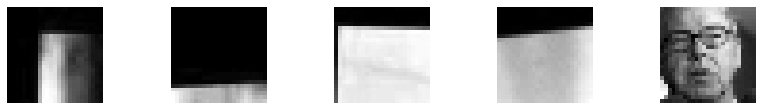

In [18]:
# 100 faces and 100 non-faces in 25x25 images
images = lfw_subset()
y = np.array([1] * 100 + [0] * 100)

def show_faces(X):
    num_samples = 5
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(3, 7.5, i + 1)
        #img = sample_digits[i].reshape((h, w))
        img = sample_digits[i]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
print('These are some exemplary images from the lfw subset:')
show_faces(images)

### Training and evaluating on a randomized train-test-split

In [19]:
X_train_face, X_test_face, y_train_face, y_test_face = train_test_split(images, y, random_state=0, shuffle=True, stratify=y)

In [20]:
# EVA: Don't the images need to be converted to gray scale values for training and testing? Paul: yep, they already are
violajones = Viola_Jones(image_shapes=(25,25), n_predictors=10)
X_train = np.array([x.ravel() for x in X_train_face])
violajones.train_viola_jones(X_train, y_train_face)

train classifier m: 0
train classifier m: 1
train classifier m: 2
train classifier m: 3
train classifier m: 4
train classifier m: 5
train classifier m: 6
train classifier m: 7
train classifier m: 8
train classifier m: 9


In [21]:
X_test = np.array([x.ravel() for x in X_test_face])
y_pred_face = violajones.predict(X_test)
y_pred_face

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1])

In [22]:
calculate_accuracy(y_test_face, y_pred_face, np.array([0,1]))

0.98

In [23]:
display_confusion_matrix(y_test_face, y_pred_face, np.array([0,1]))

,true: 0,true: 1
pred: 0,25,1
pred: 1,0,24


### Result: The Viola Jones Classifier is very accurate at deciding between non-faces and faces images

## a) Visualize the top ten face classifiers (features)
**Getting type and position of the top ten performing feature classifiers and visualizing them in randomly sampled images from the lfw subset**

In [40]:
def get_feature_type_pos(feature_classifiers, classifier):
    """
    Get type and position of features of interest within 25x25 image given their index 
    in the training feature matrix.
    """
    features = [2, 3, 4]
    feature_heights_widths = [(6,10), (5,9), (4,4)] 
    feature_counter = 0
    used_features = []
    for feature_shape, (height, width) in zip(features, feature_heights_widths):
        for i in range(classifier.shape_i - height):
            for j in range(classifier.shape_j - width):
                if feature_counter in feature_classifiers:
                    used_features.append((feature_shape, i, j))
                feature_counter += 1
    return used_features

In [41]:
violajones.classifier_list # (clf weight, feature value, parity, classification threshold)

[(2.639057329615259, 608, -1, 0.551633954048163),
 (2.5649493574615367, 301, 1, -6.862745210528391),
 (2.03688192726104, 989, -1, 0.3934641480445862),
 (2.2718861061052387, 754, -1, 0.19869279861450195),
 (1.9686879563128454, 209, 1, -0.16339868307113647),
 (1.9591729027087472, 104, -1, 0.25098023004829884),
 (2.1523473315596116, 1028, -1, 0.24575158953667575),
 (2.2661230990506587, 317, 1, -3.8183006402105106),
 (2.20317084066453, 251, 1, -0.014379113912582397),
 (2.0978501482317595, 921, 1, -0.684967175126074)]

In [42]:
feature_cols = np.array(violajones.classifier_list)[:,1].astype(int)
# [(2/3/4-rect, i, j)] where (i,j) is the upper left corner of the feature
used_features = get_feature_type_pos(feature_cols, violajones)

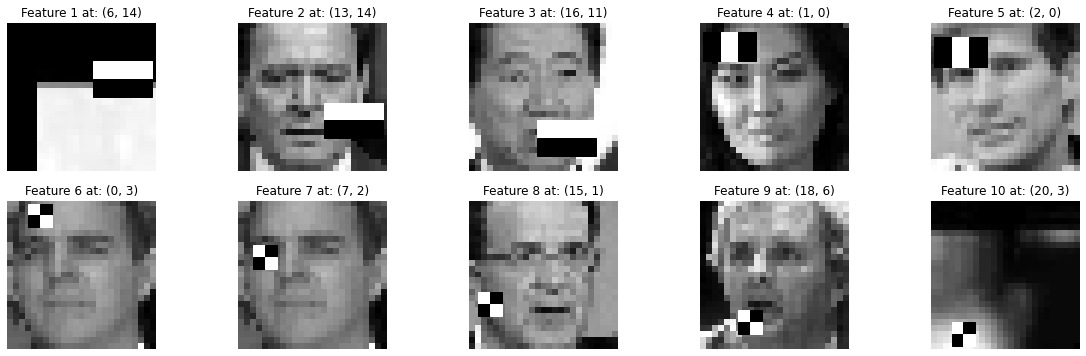

In [43]:
h = 25
w = 25
# randomly pick ten test images
num_samples = len(used_features)
indices = np.random.choice(range(len(X_test_face)), num_samples)
sample_digits = X_test_face[indices]

fig = plt.figure(figsize=(20, 6))

for i in range(num_samples):
    ax = plt.subplot(num_samples // 5, 5, i + 1)
    img = sample_digits[i].reshape((h, w))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    rect, bottom, left  = used_features[i] 
    # patches.Rectangle needs lower left corner coordinates as input, where before i=rows,j=columns now
    # needs to be interpreted as j=x-coordinate and i=y-coordinate
    if rect == 2:
        rect = patches.Rectangle((left,bottom),10,3,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
        rect = patches.Rectangle((left,bottom+3),10,3,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
    elif rect == 3:
        rect = patches.Rectangle((left,bottom),3,5,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+3,bottom),3,5,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+6,bottom),3,5,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
    elif rect == 4:
        rect = patches.Rectangle((left,bottom),2,2,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
        rect = patches.Rectangle((left,bottom+2),2,2,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+2,bottom),2,2,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+2,bottom+2),2,2,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
    ax.title.set_text("Feature {} at: (".format(i+1) + str(bottom) + ", " + str(left) + ")")
plt.show()

### Resulting features: The high performing features of this first dataset are often along the outer contour of the face

## II: 
## In the following, we train and test a Viola Jones model on images of the faces of two people in the lfw dataset, instead of faces and non-face images as we did before, just to compare the performance of "faces vs non-faces" to "face vs face"


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
image_height: 25
image_width: 25
(5,)


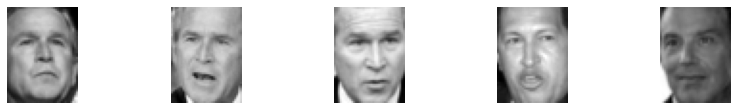

In [45]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h2, w2 = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X_faces = lfw_people.data
n_features = X_faces.shape[1]

# the label to predict is the id of the person
y_faces = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("image_height: %d" % h)
print("image_width: %d" % w)


def show_faces(X):
    num_samples = 5
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(3, 7.5, i + 1)
        img = sample_digits[i].reshape((h2, w2))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
show_faces(X_faces)

In [64]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

### Create a train-test split of two people of the lfw-faces dataset and train viola-jones on it:

In [46]:
X_sub = np.concatenate((X_faces[np.where(y_faces == 0)],X_faces[np.where(y_faces == 1)]))
y_sub = np.concatenate((y_faces[np.where(y_faces == 0)],y_faces[np.where(y_faces == 1)]))
X_train_people, X_test_people, y_train_people, y_test_people = train_test_split(X_sub, y_sub, random_state=0, shuffle=True, stratify=y_sub)

In [47]:
violajones2 = Viola_Jones(image_shapes=(h2, w2), n_predictors=10)
violajones2.train_viola_jones(X_train_people, y_train_people)

train classifier m: 0
train classifier m: 1
train classifier m: 2
train classifier m: 3
train classifier m: 4
train classifier m: 5
train classifier m: 6
train classifier m: 7
train classifier m: 8
train classifier m: 9


In [48]:
y_pred_people = violajones2.predict(X_test_people)
y_pred_people

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
display_confusion_matrix(y_test_people, y_pred_people, np.unique(y_test_people)[::-1])

,true: 1,true: 0
pred: 1,50,8
pred: 0,10,11


In [50]:
calculate_accuracy(y_test_people, y_pred_people, np.unique(y_test_people)[::-1])

0.7721518987341772

### Result: The Viola-Jones features are not so great at differenciating between these two faces

In [51]:
# [am, j, p_j, theta_j]
violajones2.classifier_list

[(1.1856818007987044, 187, -1, -43.33349609375),
 (1.101168796874956, 3790, -1, 53.66667175292969),
 (1.106574867809197, 1144, 1, 30.333328247070312),
 (1.0597045904940228, 3163, 1, 56.66668701171875),
 (1.1469473630691074, 3266, 1, 48.33335876464844),
 (1.1019649925085722, 3778, 1, -18.333351135253906),
 (1.2089168286272334, 3, -1, -76.33333587646484),
 (0.9465446024062849, 55, 1, -2.3333206176757812),
 (0.9690171240892828, 750, 1, 4.666656494140625),
 (0.8939424411447898, 329, 1, -130.33333587646484)]

### Extract again, which rect-feature and at what position the feature at position j was and show them on random samples of the faces:

In [52]:
feature_cols = np.array(violajones2.classifier_list)[:,1].astype(int)
print(feature_cols)
used_features = get_feature_type_pos(feature_cols, violajones2)
# [(2/3/4-rect, i, j)] where (i,j) is the upper left corner of the feature
used_features

[ 187 3790 1144 3163 3266 3778    3   55  750  329]


[(2, 0, 3),
 (2, 2, 1),
 (2, 6, 25),
 (2, 12, 5),
 (2, 27, 21),
 (2, 42, 10),
 (4, 21, 22),
 (4, 24, 26),
 (4, 40, 10),
 (4, 40, 22)]

In [53]:
used_features

[(2, 0, 3),
 (2, 2, 1),
 (2, 6, 25),
 (2, 12, 5),
 (2, 27, 21),
 (2, 42, 10),
 (4, 21, 22),
 (4, 24, 26),
 (4, 40, 10),
 (4, 40, 22)]

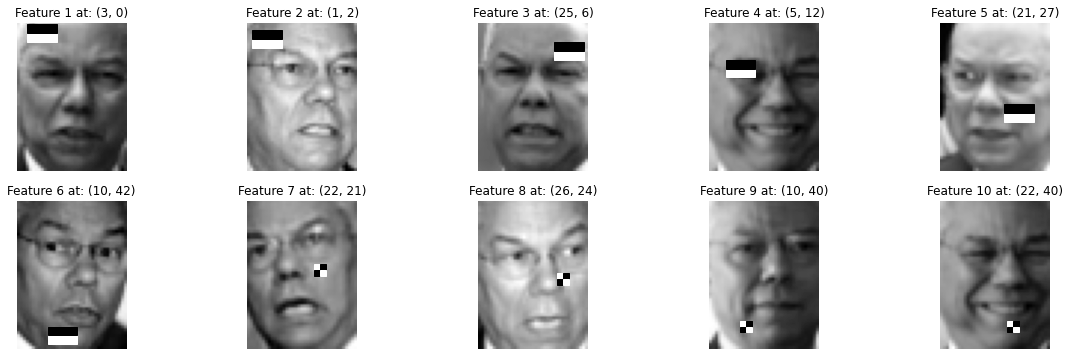

In [55]:
num_samples = len(used_features)
indices = np.random.choice(range(len(X_test_people)), num_samples)
sample_digits = X_test_people[indices]

fig = plt.figure(figsize=(20, 6))

for i in range(num_samples):
    ax = plt.subplot(num_samples // 5, 5, i + 1)
    img = sample_digits[i].reshape((h2,w2))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    rect, bottom, left = used_features[i]
    if rect == 2:
        rect = patches.Rectangle((left,bottom+3),10,3,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
        rect = patches.Rectangle((left,bottom),10,3,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
    elif rect == 3:
        rect = patches.Rectangle((left,bottom),3,5,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+3,bottom),3,5,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+6,bottom),3,5,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
    elif rect == 4:
        rect = patches.Rectangle((left,bottom),2,2,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+2,bottom),2,2,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
        rect = patches.Rectangle((left,bottom+2),2,2,linewidth=1, fill=True, color="black")
        ax.add_patch(rect)
        rect = patches.Rectangle((left+2,bottom+2),2,2,linewidth=1, fill=True, color="white")
        ax.add_patch(rect)
    ax.title.set_text("Feature {} at: (".format(i+1) + str(left) + ", " + str(bottom) + ")")
plt.show()

### Resulting features: The high performing features of this second "face vs face" dataset are often along the contours of the eyes, nose or mouth

# Excercise 3 (Bonus). Cascade-Classification
Implement a cascade algorithm to classify faces in a picture of your choice (there should be
more than a face on your image, e.g. skimage.data.astronaut())

In [56]:
class CascadeClassifier:
    def __init__(self, image_shapes, fpr_reduction, tpr_reduction, fpr_target):
        self.image_shapes = image_shapes
        self.fpr_target = fpr_target
        self.fpr_reduction = fpr_reduction
        self.tpr_reduction = tpr_reduction
        self.C_i_list = None
    
    def calculate_cm(self, y_true, y_pred):
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        return tp, fp, fn, tn

    def calculate_tpr(self, tp, fp, fn, tn):
        return (tp)/(tp + fn)

    def calculate_fpr(self, tp, fp, fn, tn):
        return (fp)/(fp + tn)
    
    def train_cascade(self, X_train, X_val, y_train, y_val):
        F_i = 1
        D_i = 1
        i = 0
        n_i = 0
        self.C_i_list = []
        while F_i > self.fpr_target:
            i += 1
            F_prev = F_i
            D_prev = D_i
            print("Cascade i =", i)
            # n_i = 0 <- moved up because it just wastes iterations by searching small n's again
            C_i = None
            # '<' <- in the slides is wrong, the algorithm would never enter this loop if the condition 
            # was F_i < self.fpr_reduction * F_prev because F_i = F_prev and self.fpr_reduction is a value smaller 1
            while F_i > self.fpr_reduction * F_prev: 
                n_i += 1
                print("    F_i loop, n_i =", n_i)
                print("    F_i:",F_i, ">", self.fpr_reduction * F_prev)
                C_i = Viola_Jones(image_shapes=self.image_shapes, n_predictors=n_i)
                C_i.train_viola_jones(X_train, y_train)
                cutoff_C_i = 0.5
                y_pred_i = C_i.predict(X_val, cutoff=cutoff_C_i)
                tp, fp, fn, tn = self.calculate_cm(y_val, y_pred_i)
                D_i = self.calculate_tpr(tp, fp, fn, tn)
                #F_i = self.calculate_fpr(tp, fp, fn, tn)
                while D_i <= self.tpr_reduction * D_prev and cutoff_C_i > 0.1:
                    print("        D_i:",D_i, "<=", self.tpr_reduction * D_prev)
                    cutoff_C_i -= 0.1
                    print("        cutoff:", cutoff_C_i)
                    y_pred_i = C_i.predict(X_val, cutoff=cutoff_C_i)
                    tp, fp, fn, tn = self.calculate_cm(y_val, y_pred_i)
                    D_i = self.calculate_tpr(tp, fp, fn, tn)
                    print("        D_i test:",D_i, ">", self.tpr_reduction * D_prev, "is", D_i > self.tpr_reduction * D_prev)
                    if D_i > self.tpr_reduction * D_prev:
                        F_i = self.calculate_fpr(tp, fp, fn, tn)
                print("    D_i:", D_i, "F_i:", F_i)
            if not C_i is None:
                self.C_i_list.append((cutoff_C_i, C_i))
    
    def predict_cascade(self, X_test):
        y_pred = np.ones(len(X_test))
        for cutoff_C_i, C_i in self.C_i_list:
            for i in range(len(y_pred)):
                if y_pred[i] == 1:
                    y_pred[i] = C_i.predict(X_test[i].reshape((1,X_test.shape[1])), cutoff=cutoff_C_i)
        return y_pred

## We train the cascade on the lfw_subset:
We used the lfw_subset for training instead of subframes of the recommended skimage.data.astronaut(), because we have labeled images in lfw_subset. <br>
But skimage.data.astronaut() might be used as a testing image.

In [57]:
X_train_cascade, X_val_cascade, y_train_cascade, y_val_cascade = train_test_split(np.array([x.ravel() for x in X_train_face]), y_train_face, random_state=0, shuffle=True, stratify=y_train_face)

In [58]:
CC = CascadeClassifier((25,25), 0.9, 0.99, 0.11)
CC.train_cascade(X_train_cascade, X_val_cascade, y_train_cascade, y_val_cascade)

Cascade i = 1
    F_i loop, n_i = 1
    F_i: 1 > 0.9
train classifier m: 0
        D_i: 0.9473684210526315 <= 0.99
        cutoff: 0.4
        D_i test: 0.9473684210526315 > 0.99 is False
        D_i: 0.9473684210526315 <= 0.99
        cutoff: 0.30000000000000004
        D_i test: 0.9473684210526315 > 0.99 is False
        D_i: 0.9473684210526315 <= 0.99
        cutoff: 0.20000000000000004
        D_i test: 0.9473684210526315 > 0.99 is False
        D_i: 0.9473684210526315 <= 0.99
        cutoff: 0.10000000000000003
        D_i test: 0.9473684210526315 > 0.99 is False
        D_i: 0.9473684210526315 <= 0.99
        cutoff: 2.7755575615628914e-17
        D_i test: 0.9473684210526315 > 0.99 is False
    D_i: 0.9473684210526315 F_i: 1
    F_i loop, n_i = 2
    F_i: 1 > 0.9
train classifier m: 0
train classifier m: 1
        D_i: 0.8947368421052632 <= 0.99
        cutoff: 0.4
        D_i test: 1.0 > 0.99 is True
    D_i: 1.0 F_i: 0.47368421052631576
Cascade i = 2
    F_i loop, n_i = 3
    

In [60]:
clf_list = CC.C_i_list
#for clf_list

In [61]:
y_pred_cascade = CC.predict_cascade(np.array([x.ravel() for x in X_test_face]))
y_pred_cascade

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.])

In [62]:
display_confusion_matrix(y_test_face, y_pred_cascade, np.unique(y_test_face)[::-1])

,true: 1,true: 0
pred: 1,24,1
pred: 0,1,24


In [63]:
calculate_accuracy(y_test_face, y_pred_cascade, np.unique(y_test_face)[::-1])

0.96